In [71]:
import time
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
from collections import Counter
import string
from sklearn import linear_model
import ast
import importlib
import numpy as np
from scipy.spatial import distance
import random
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
nltk.download("averaged_perceptron_tagger")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Charlie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
import as2_analysis_utils as as2_analysis

importlib.reload(as2_analysis)

<module 'as2_analysis_utils' from '/Users/Charlie/Documents/Work_School/UCSD/Grad/Fall_2020/CSE258/assignment2/as2_analysis_utils.py'>

In [13]:
data_all = list(as2_analysis.parseData_line("renttherunway_final_data.json"))

In [14]:
def extract_features(data_all, key):
    """
    return data of particualr key
    """
    return [d[key] for d in data_all]

In [29]:
ratings_all = extract_features(data_all,"rating")

In [31]:
ratings_all = [int(i) for i in ratings_all if i != "null"]

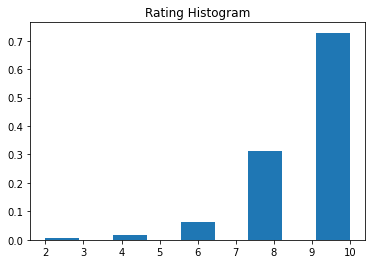

In [46]:
plt.hist(ratings_all,bins=9,density = True)
plt.title("Rating Histogram")
plt.savefig("Rating Histogram.pdf",bbox_inches="tight")

In [48]:
rating_fit = [int(d["rating"]) for d in data_all if d["fit"]=="fit" and d["rating"]!="null"]
rating_small = [int(d["rating"]) for d in data_all if d["fit"]=="small" and d["rating"]!="null"]
rating_large = [int(d["rating"]) for d in data_all if d["fit"]=="large" and d["rating"]!="null"]

In [49]:
def plot_hist(data,title="",bins=9):
    plt.hist(data,bins=9,density = True)
    plt.title(title)
    plt.savefig(title +".pdf",bbox_inches="tight")

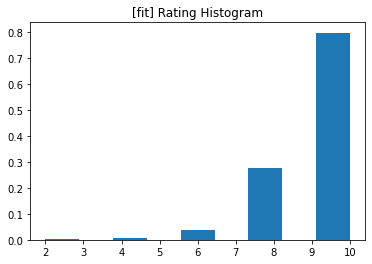

In [50]:
plot_hist(rating_fit,title="[fit] Rating Histogram",bins=9)

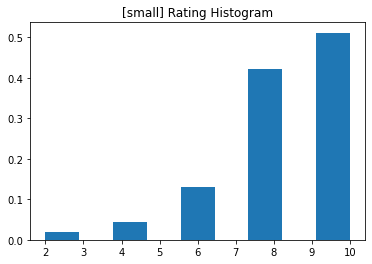

In [51]:
plot_hist(rating_small,title="[small] Rating Histogram",bins=9)

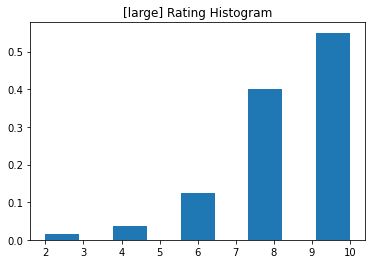

In [52]:
plot_hist(rating_large,title="[large] Rating Histogram",bins=9)

In [59]:
data_rating_dict = defaultdict(list)
for d in data_all:
    rating = d["rating"]
    if rating != "null":
        data = d["review_date"]
        data_rating_dict[data].append(int(rating))

In [64]:
data_rating_avg = {key: np.mean(val) for key,val in data_rating_dict.items()}

In [66]:
dates = list(data_rating_avg.keys())

In [68]:
dates.sort()

In [70]:
from datetime import datetime

datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

In [63]:
sum(x)

NameError: name 'mean' is not defined

 # Count word frequency

In [13]:
# top words in fit reviews
fit_reviews_all = [
    d["review_text"] + " " + d["review_summary"] for d in data_all if d["fit"] == "fit"
]
small_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "small"
]
large_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "large"
]



In [14]:
def tokenize_data_sets(dataset, n=1):
    """
    Each item of dataset is a str
    """
    return [as2_analysis.tokenize_paragraph(d, n=n) for d in dataset]



In [15]:
# tokenize dataset
fit_tokenized_all = tokenize_data_sets(fit_reviews_all)
small_tokenized_all = tokenize_data_sets(small_reviews_all)
large_tokenized_all = tokenize_data_sets(large_reviews_all)



In [16]:
fit_word_count = as2_analysis.count_word_freq(fit_tokenized_all)
small_word_count = as2_analysis.count_word_freq(small_tokenized_all)
large_word_count = as2_analysis.count_word_freq(large_tokenized_all)


 # Get most frequent adjective

In [17]:
def top_n_adj(word_count_dict):
    ## get the most common ajectives
    adj_count = {
        key: word_count_dict[key]
        for key in word_count_dict
        if nltk.pos_tag([key])[0][1][0] == "J"
    }

    # sort them into pairs
    adj_count_pair = [(count, key) for key, count in adj_count.items()]

    # sort
    adj_count_pair.sort(reverse=True)

    return adj_count_pair



In [18]:
start = time.time()
top_small_adj = top_n_adj(small_word_count)


top_big_adj = top_n_adj(large_word_count)


## get the most common ajectives
adj_fit_count = {
    key: fit_word_count[key]
    for key in fit_word_count
    if nltk.pos_tag([key])[0][1][0] == "J"
}

end = time.time()
print(f"time consume: {end-start}s")

time consume: 12.169735193252563s


In [19]:
adj_fit_count_pair = [(count, key) for key, count in adj_fit_count.items()]



In [20]:
adj_fit_count_pair.sort(reverse=True)



In [21]:
adj_fit_count_pair[:10]



[(60010, 'great'),
 (48689, 'comfortable'),
 (39921, 'little'),
 (22857, 'many'),
 (18916, 'true'),
 (17789, 'short'),
 (15455, 'black'),
 (13260, 'gorgeous'),
 (12799, 'much'),
 (11649, 'nice')]

In [22]:
top_small_adj[:10]



[(11137, 'small'),
 (9126, 'great'),
 (8424, 'little'),
 (5654, 'comfortable'),
 (4705, 'short'),
 (3386, 'many'),
 (2854, 'gorgeous'),
 (2675, 'overall'),
 (2623, 'much'),
 (2620, 'other')]

In [23]:
top_big_adj[:10]



[(9276, 'great'),
 (8972, 'little'),
 (8489, 'large'),
 (7584, 'comfortable'),
 (7517, 'big'),
 (3201, 'small'),
 (3011, 'many'),
 (2654, 'much'),
 (2602, 'overall'),
 (2406, 'smaller')]

 Try bigram and trigram

In [24]:
def top_n_adj_n_gram(word_count_dict):

    ## get the most common ajectives
    adj_count = {
        key: word_count_dict[key]
        for key in word_count_dict
        # if either of the word is an adj, preserve
        if any(
            wordType[0] == "J"
            for _, wordType in nltk.pos_tag(key if type(key) == tuple else (key,))
        )
    }

    # sort them into pairs
    adj_count_pair = list(adj_count.items())

    # # sort
    adj_count_pair.sort(reverse=True, key=lambda x: x[1])

    return adj_count_pair



In [25]:
def top_adj_pipeline(fit_reviews_all, small_reviews_all, large_reviews_all, n=2):

    fit_tokenized_all = tokenize_data_sets(fit_reviews_all, n)
    small_tokenized_all = tokenize_data_sets(small_reviews_all, n)
    large_tokenized_all = tokenize_data_sets(large_reviews_all, n)

    fit_word_count = as2_analysis.count_word_freq(fit_tokenized_all)
    small_word_count = as2_analysis.count_word_freq(small_tokenized_all)
    large_word_count = as2_analysis.count_word_freq(large_tokenized_all)

    start = time.time()
    top_fit_grams = top_n_adj_n_gram(fit_word_count)
    top_small_grams = top_n_adj_n_gram(small_word_count)
    top_large_grams = top_n_adj_n_gram(large_word_count)
    end = time.time()
    print(f"time consume: {end-start}s")
    return top_fit_grams, top_small_grams, top_large_grams



In [26]:
top_fit_grams, top_small_grams, top_large_grams = top_adj_pipeline(
    fit_reviews_all, small_reviews_all, large_reviews_all, 2
)

time consume: 187.62095403671265s


In [27]:

top_fit_grams[:10]

[(('a', 'little'), 37021),
 (('was', 'perfect'), 21087),
 (('many', 'compliments'), 18749),
 (('true', 'to'), 17248),
 (('so', 'i'), 16506),
 (('so', 'many'), 14559),
 (('comfortable', 'and'), 12829),
 (('very', 'comfortable'), 11175),
 (('the', 'top'), 9822),
 (('a', 'great'), 9118)]

In [28]:
top_small_grams[:10]

[(('a', 'little'), 7847),
 (('so', 'i'), 4534),
 (('many', 'compliments'), 2749),
 (('was', 'perfect'), 2652),
 (('runs', 'small'), 2557),
 (('the', 'top'), 2184),
 (('so', 'many'), 2041),
 (('able', 'to'), 1758),
 (('beautiful', 'dress'), 1729),
 (('small', 'i'), 1694)]

In [29]:
top_large_grams[:10]



[(('a', 'little'), 8558),
 (('so', 'i'), 3870),
 (('was', 'perfect'), 2582),
 (('the', 'top'), 2401),
 (('many', 'compliments'), 2366),
 (('too', 'big'), 2096),
 (('comfortable', 'and'), 2026),
 (('runs', 'large'), 1842),
 (('so', 'many'), 1829),
 (('very', 'comfortable'), 1735)]

 # Data Prediction

In [30]:
random.shuffle(data_all)

In [31]:
data_size = len(data_all)
valid_percent = 0.2
test_percent = 0.2


In [32]:
data_train = data_all[: int(data_size * (1 - valid_percent - test_percent))]
data_valid = data_all[
    int(data_size * (1 - valid_percent - test_percent)) : int(
        data_size * (1 - test_percent)
    )
]
data_test = data_all[int(data_size * (1 - test_percent)) :]


In [33]:
def extract_review(data):
    fit_reviews = [
        d["review_text"] + " " + d["review_summary"] for d in data if d["fit"] == "fit"
    ]
    small_reviews = [
        d["review_text"] + " " + d["review_summary"]
        for d in data
        if d["fit"] == "small"
    ]
    large_reviews = [
        d["review_text"] + " " + d["review_summary"]
        for d in data
        if d["fit"] == "large"
    ]
    return fit_reviews, small_reviews, large_reviews



 Try n-gram BoW logistic regression

In [34]:
n = 1
fit_reviews_train, small_reviews_train, large_reviews_train = extract_review(data_train)


In [35]:
top_fit_grams, top_small_grams, top_large_grams = top_adj_pipeline(
    fit_reviews_train, small_reviews_train, large_reviews_train, n
)


time consume: 8.67733097076416s


In [36]:
threshold = 500
top_word_set = {word for word, _ in top_fit_grams[:threshold]}.union(
    {word for word, _ in top_small_grams[:threshold]}.union(
        {word for word, _ in top_large_grams[:threshold]}
    )
)
wordId = dict(zip(top_word_set, range(len(top_word_set))))

In [37]:
def feature(d, n=1):
    feat = [0] * len(top_word_set)
    review = d["review_text"] + " " + d["review_summary"]
    p_list = as2_analysis.tokenize_paragraph(review, n=1)
    for word in p_list:
        if word not in top_word_set:
            continue
        # use BoW for now
        feat[wordId[word]] += 1
    return feat



In [38]:
def encode_output(data):
    return [0 if d["fit"] == "fit" else 1 if d["fit"] == "small" else 2 for d in data]



In [39]:
FIT = 0
SMALL = 1
BIG = 2
X_train = [feature(d, n) for d in data_train]
y_train = encode_output(data_train)
X_valid = [feature(d, n) for d in data_valid]
y_valid = encode_output(data_valid)


In [40]:
model = linear_model.LogisticRegression(C=1000)

In [41]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [42]:
np.mean(y_pred == y_valid)


0.758498013451401